In [1]:
import pickle
from astropy.io import fits
from ctapipe.io import EventSource
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
import numpy as np
import copy
from ctapipe.image import number_of_islands
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.calib import CameraCalibrator
import json
from traitlets.config import Config
from lstchain.io import replace_config, standard_config
from ctapipe_io_lst import calibration
from ctapipe.io import HDF5TableReader, read_table
from ctapipe.containers import FlatFieldContainer, MonitoringCameraContainer, MonitoringContainer, PedestalContainer, PixelStatusContainer, WaveformCalibrationContainer
import tables
import os

## R1 max amplitude time samples for events from stereo simulations, on which was build cleaning algorithm

In [35]:
flagged_rings_sim = [5333507, 1673009, 1808303, 3362305, 2835508, 4026706, 159503, 4854202, 5464504, 2439702, 1402200, 3456509, 3547004, 2229705, 22604, 5573308, 3489206, 417000, 5895006, 1836008, 1794401, 593906, 3280901, 1114103, 5920700, 5521903, 5240406, 5678007, 918003, 5858809, 4315801, 3547006, 729206, 5412204, 759808, 3386907, 2597005, 3539901, 4125904, 1073405, 3662503, 846606, 2845905, 5139408, 5097001, 3248609, 2257305, 5559707, 1775404, 5586609, 5387503, 336801, 3611003, 4504102, 1556201, 3742006, 55203, 377809, 5303909, 3393108, 5854105, 3850800, 5240903, 5120108, 4330605, 4006201, 4752000, 817501, 1096109, 5562603, 3289408, 2057308, 1646106, 2736603, 220203, 2095301, 243205, 250008, 728702, 1177701, 402700, 4589808, 1063003, 3804102, 1088507, 5638409, 1824304, 2482107, 2619809, 4647903, 5864908, 4805401, 2936707, 996201]
ring_9222 = [13, 14, 15, 15, 15, 15, 15, 16,  3, 39, 15, 14, 14,  0, 12, 13, 36,
       15, 14, 13, 14, 13, 13, 14, 12,  2, 14, 14, 15, 15, 15, 34, 14, 15,
       13, 14, 26,  9,  5, 15, 15, 14, 14, 14, 13, 14, 39, 15, 15, 14, 13,
       16, 14, 14, 32, 14, 15, 14, 15, 14, 14,  0, 15, 14, 16]

ring_2223 = [ 0, 14,  7, 15, 15, 14, 23, 17, 10, 10, 14, 13, 14, 14, 16, 13, 14,
       17, 14, 14, 16, 10, 22, 14, 38,  0, 14, 26,  0, 15,  3, 13, 12, 19,
       14, 14, 14,  3, 11, 14, 14, 15, 16, 13, 19,  7, 27, 11, 16, 14, 18,
       15,  0,  9, 15, 14, 32,  6, 28, 15, 17, 32, 13, 10,  6, 25, 15, 37,
       13, 26, 16, 26, 15, 30, 12,  1, 14, 13, 31, 27, 19, 15, 15, 20, 19,
       21, 33, 16, 15,  5, 36, 12, 38, 22, 18, 15, 12, 14, 14, 12,  4,  7,
       18, 25, 38, 26, 14, 14, 21, 16, 14, 15, 32, 31,  2,  0, 14, 14,  1,
        1, 19, 15,  3, 13, 22, 31, 25, 34, 17, 16, 15, 16,  9, 15, 34, 12,
        4, 13, 18, 32,  3, 15, 14, 31, 13, 17, 28,  9, 13, 39, 22, 15, 16,
       14, 15, 31,  0, 18,  3, 14, 19, 15, 16,  7, 15, 25, 12, 26, 15,  1,
       14, 28, 16, 15, 14, 13,  8, 11,  9,  2, 10, 13, 16]

proton_2223 = [19, 19, 18, 17, 17, 18, 17, 17, 17, 17, 17, 17, 18, 16, 17, 16, 17,
       18, 16, 18, 16, 17, 18, 17, 17, 18, 17, 16, 17, 16, 17, 17, 17, 17,
       16, 18, 15, 16, 16, 18, 17, 16]
proton_9222 = [20, 19, 20, 20, 22, 22, 22, 20, 19, 19, 21, 22, 20, 19, 20, 34, 19,
       19, 19, 17, 19, 19, 20, 18, 20, 19, 19, 20, 19, 18, 19, 19, 18, 21,
       19, 18, 19, 20, 17, 19, 19, 21]

proton_2438 = [16, 17, 16, 17, 16, 16, 17, 17, 17, 17, 18, 17, 19, 18, 18, 17, 17,
       20, 18, 18, 20, 19, 18, 16, 18, 17, 19, 20, 21, 18, 20, 19, 19, 18,
       19, 20, 18, 20, 19, 20, 18, 17, 18, 19, 20, 19, 17, 17, 18, 17, 18,
       16, 16, 17, 17, 18]

ring_2438 = [15, 15, 14, 15, 15, 15, 15, 14, 14, 13, 14, 13, 14, 14, 13, 13, 14,
       13, 15, 16, 14, 14, 15, 13, 14, 15, 14, 14, 15, 15, 13, 15, 15, 13,
       14, 14, 18, 14, 13, 14, 15, 14, 13, 14, 39, 13, 17, 14, 13, 14, 14,
       15, 14, 14, 12, 15, 13, 14, 14, 14, 13, 15, 13, 14, 15, 12, 15, 14,
       23, 14]

proton_25051 = [18, 17, 17, 17, 19, 20, 19, 20, 21, 20, 18, 19, 19, 21, 21, 21, 19,
       19, 20, 20, 20, 20, 19, 20, 19, 19, 20, 18, 19, 20, 19, 18, 18, 19,
       19, 19, 19]
ring_25051 = [14, 14, 15, 13, 14, 14, 12, 13, 14, 13, 13, 14, 15, 14, 15, 14, 14,
       13, 14, 14, 14, 14, 13, 15, 14, 15, 14, 14, 14, 14, 13, 15, 13, 13,
       14, 12, 14, 16, 14, 13, 16, 13, 14, 15, 13, 15, 13, 15, 13, 15, 15,
       14, 14, 13, 14, 14, 14, 13, 22, 15, 13, 13, 16, 15, 14,  7, 30, 14,
       13, 13, 11, 13, 14, 15, 15, 13, 15, 14, 13, 14, 13, 14, 13, 15]

# event not separated in time
# Separated by double cut (shower on sample 20 intensity > 0.9, ring on sample 12 intensity > 1.2)
# then pixels of shower was subtracted from ring pixels
#
ring_14406 = [13, 13, 13, 16, 20, 13, 12, 14, 15, 15, 14, 13, 13, 14, 12, 15, 14,
       14, 15, 13, 14, 15, 24, 15, 14, 12, 15, 14, 14, 10, 14, 13, 15, 14,
       17, 15, 14, 14, 13, 15, 14, 14, 15, 15, 15, 14, 13, 14, 13, 15, 14,
       14, 13, 13, 15, 10, 14, 15, 13, 13, 15, 15, 17, 16, 13, 16, 14, 14,
       16, 13, 13, 15, 15, 17, 14, 15, 15, 14, 14,  4, 16, 15, 15, 14, 15,
       14, 14, 15, 14, 15, 19, 13, 14, 12, 15, 15, 13, 14, 16, 39, 14, 15,
       14, 15, 14, 14, 12, 13, 14, 27]

proton_14406 = [15, 16, 15, 15, 15, 20, 15, 15, 16, 15, 18, 15, 14, 15, 16, 16, 14,
       14, 15, 15, 37, 14, 15, 15, 14, 14]

#
#

ring_22126 = [16, 15, 14, 14, 14, 14, 13, 14, 14, 15, 16, 14, 15, 13, 13, 14, 15,
       29, 15, 13, 14, 23, 13, 14, 15, 15, 16, 14, 13, 15, 15, 14, 13, 13,
       23, 38, 15, 15, 15, 14, 11, 14, 13, 13, 13, 14, 13, 15, 15, 14, 13,
       15, 15, 29, 15, 15, 13, 13, 14, 13, 14, 15, 12, 15, 14, 15, 15, 15,
       14, 14, 10, 13, 15, 15, 15, 14, 14, 34, 39, 14]

proton_22126 = [23, 20, 25, 24, 19, 20, 24,  5, 20, 21, 21, 24, 22, 22, 21, 22, 20,
       23, 20, 22, 21, 23, 24, 24, 22, 23, 20, 19, 21, 21, 22, 20, 23, 23,
       21, 22, 21, 21, 21, 23, 22, 21, 21, 22, 23, 17, 15,  4, 21, 20, 20,
       20, 21, 20, 20, 20, 20, 25, 20, 22, 20, 21, 21, 21, 21, 21, 23]


ring_22365 = [15, 12, 14, 12, 13, 16, 14, 14, 14, 14, 14, 14, 13, 14, 14, 14, 14,
       13, 13, 14, 13, 13, 14, 13, 14, 14, 14, 13, 14, 13, 14, 12, 14, 15,
       24, 14, 15, 13, 13, 14, 13, 13, 19, 13, 14, 13, 15, 13, 14, 13, 12,
       14, 15, 14, 14, 12, 14, 14, 13, 38, 15, 14, 14, 13, 13, 14, 13, 13,
       11, 13, 12, 12, 14, 13, 14, 28, 13, 14, 35, 14, 13, 15, 13, 12, 15,
       28, 15, 12, 11, 12, 13,  8, 13, 13]

proton_22365 = [22, 20, 22, 19, 19, 23, 20, 21, 18, 19, 21, 22, 24, 22, 21, 22, 20,
       19, 14, 24, 24, 21, 22, 20, 21, 20, 22, 20, 23, 21, 22, 20, 23, 21,
       20, 22, 21, 11, 20, 19, 20, 19, 38, 20, 19, 20, 21, 22, 21, 19, 19,
       19, 20, 13, 20, 20, 21, 21, 21, 20, 23, 21, 22]

ring_32298 = [6, 25, 14, 12, 14, 14, 15, 14, 15, 15,  9, 17, 23,  1, 13, 11, 15,
       12, 14, 14, 16, 39, 13, 15, 12, 13,  0, 15, 13, 13, 15, 13,  3, 16,
       11, 13, 14, 15, 29, 14, 14, 25, 14,  5, 14, 11, 14, 19, 14, 14, 28,
       14, 14, 14, 16, 14, 14, 14, 13, 14, 13]

proton_32298 = [11, 19, 19, 14, 13, 15, 14, 24, 37, 15, 13, 17, 18, 16, 17, 18, 17,
       15, 17, 17, 17,  1, 19, 10,  7, 16,  7, 14, 16, 22, 13, 14]

ring_35219 = [29, 15, 14, 11, 13, 13, 16, 13, 13, 14, 13, 13, 14, 12, 13, 13, 15,
       12, 12, 14, 14, 16, 14, 14, 14, 14, 14, 14, 33, 14, 14, 15, 13, 17,
       14, 14,  3, 15, 14, 15, 35, 14, 14, 14, 13, 13, 14, 15, 13, 13, 14,
       14, 14, 19, 31, 12, 13, 14, 13, 15, 13, 15, 14, 14]

proton_35219 = [17, 16, 17, 17, 17, 15, 15, 18, 18, 13, 15, 16, 13, 15, 15]

ring_28000 = [15, 15, 15, 14, 15, 15,  8,  2, 15, 13, 11, 15, 39, 15, 12, 14, 15,
       15, 12, 15, 14, 14, 14, 14, 13, 15, 15, 14, 15, 14, 15, 14, 14, 14,
       15, 11, 14, 14, 15, 14, 14, 17, 17, 14, 13, 14, 15, 14, 16, 13, 12,
       14, 15, 14, 12, 13, 15, 15, 14, 15, 15, 17, 15, 14, 13, 21, 13, 16,
       14, 14, 15, 14, 13, 13, 13, 14, 13, 15, 14, 13,  4, 14, 12, 14, 16,
       14, 14, 14, 10, 15, 24, 15, 14, 13,  5, 14, 13, 12, 16, 14, 11, 13,
       24]

proton_28000 = [19, 24, 21, 20, 21, 20, 22, 21, 22, 21,  4, 22, 21, 19, 19, 18, 21,
       22, 18, 16,  8, 24, 23, 21, 20, 20, 18, 20, 23, 21, 21, 19, 21,  2,
       22, 19, 21, 20]

ring_35298 = [13, 14, 14, 15, 14, 12, 15, 14, 13, 34, 14, 14, 14, 12, 14, 35, 14,
       14, 14, 13, 13, 25, 15, 13, 15, 14,  0, 13, 14, 13, 15, 12, 15, 13,
       13, 13, 13, 12, 13, 14, 13, 13, 14, 14, 15, 13,  3, 14, 13, 14, 13,
       15]

proton_35298 = [14, 14,  5, 36, 15, 19, 18, 15, 10, 21, 21, 18, 19, 19, 20, 19, 19,
       18, 19, 22, 31, 20, 24]


###
###
### Fitted Events

proton_8234 = [ 0, 19, 20,  5, 20, 21, 21, 21, 19, 21, 20, 19, 21, 19, 19, 19, 20,
                20, 16, 21, 18, 21, 22, 18, 18, 19, 20, 20,  0, 20, 19, 20, 18, 20]

ring_8234 = [13, 14, 12, 17, 15, 13, 12, 14, 14, 16, 15, 13, 14, 15, 13, 14, 14,
        0, 13, 15, 13, 15, 13, 14, 14, 15, 14, 13, 15, 13, 16, 15, 14, 15,
       12,  9, 14, 15, 14, 15, 13, 14, 13, 15, 14, 15, 14, 14, 14, 14, 11,
       14,  2, 14, 15, 15, 16, 13, 14, 15, 12]


proton_8448 = [24, 21, 19, 18, 20, 22, 22, 22, 21, 22, 22, 22, 19, 20, 20, 19, 20,
       19, 19, 19, 20, 20, 19]

ring_8448 = [14, 15, 15,  8, 11, 13, 14, 24, 15, 14, 12, 15, 13, 17, 14, 11, 13,
       15, 20, 35, 16, 14, 17, 17, 14, 13, 15, 15, 14, 13, 13, 15, 13, 14,
       15, 15, 13, 16, 14, 13, 14, 15, 12, 15, 14, 15, 11, 17, 14, 13, 13,
       13, 16, 15, 14, 14, 14, 14, 15]

proton_9404 = [22, 22, 19, 22, 20, 21, 20, 21, 22, 20,  3, 19, 21, 23, 20, 19, 23,
       21, 19, 21, 23, 20, 18, 21, 23]

ring_9404 = [12, 14, 13, 12, 13, 13, 14, 24, 14, 12, 14, 13,  4, 13, 13, 12, 14,
       14, 21, 13, 13, 14, 13, 13, 14, 18, 14, 13, 15, 16, 13, 14, 18, 14,
       35, 14, 12, 13, 14, 15, 13, 23, 15, 14, 31, 14, 13, 14, 14, 13, 24,
       14, 15, 14, 13, 13, 14, 13,  9, 12, 11,  9, 13, 14, 13, 30, 13, 15,
       14, 12, 14, 12, 15, 15, 13, 22, 16, 15, 22, 12, 14, 13, 14, 13, 14,
       13, 15, 14, 17, 14, 15, 15, 13, 13, 12, 12, 15, 29, 14, 13, 16, 15,
       15, 15, 13]

ring_9433 = [31, 13, 14, 15,  8, 12, 14, 14, 13, 13, 14, 14, 13, 14, 15, 32, 14,
       14, 13, 15, 12, 15, 15, 12, 14, 14, 14, 14, 17, 13, 14, 14, 14, 13,
       14,  7, 14, 15, 12, 14, 14, 15, 13, 14, 14, 14, 33, 15, 13, 14, 12,
       15, 13, 13, 15, 13, 14, 14, 13, 14, 16, 14, 12, 15, 23, 12, 17, 14,
       13, 23, 15]

proton_9433 = [33, 21, 19, 20, 19, 19, 19, 18, 20, 20, 21, 20, 11, 20, 21, 21, 18,
       19, 20]


ring_27374 = [12, 15, 24, 14, 15, 13,  8, 13, 13, 15, 13, 39, 11, 14, 30, 14, 14,
       12, 14, 21, 14, 14, 13, 14, 14, 16, 13, 12, 13, 14, 15, 15, 15, 14,
       24, 15, 13, 16, 14, 14, 14, 14, 15,  0, 13, 14, 14, 14, 13, 14, 15,
       14, 14, 14, 12, 15, 14, 12, 12, 15, 14, 14, 13, 15, 14, 15, 15, 11,
       14, 14, 14, 14, 14, 13, 12, 13,  1, 14, 23, 13, 14, 36, 14, 22, 13,
       14, 15, 11, 25, 14, 16, 26,  9, 14, 15, 13, 13, 14, 13, 12, 14, 13,
       14]
proton_27374 = [18, 16, 17, 17, 17, 17, 31, 19, 16,  1, 13]

ring_28328 = [13, 14, 14, 13, 16, 14, 17, 15, 13, 13, 14, 15, 14, 15, 15, 14, 16,
       16, 14, 14, 12, 13, 15, 13, 11, 23, 14, 15, 16, 33, 13, 14, 14, 15,
       13, 13, 15, 13,  1, 15, 15, 14, 15, 14, 22, 15, 13, 13, 15, 15, 15,
       15, 15, 16,  7, 27, 12, 16, 14, 22, 13, 15, 13, 13, 14, 12,  1, 15,
       15,  0, 14, 15, 13, 16, 13, 14, 14,  7, 15, 36, 14, 14, 13, 15, 27,
       14, 13, 14, 15, 13, 14,  2, 14, 12, 15, 26, 19, 10, 13, 15, 13, 12,
       26, 14,  0, 22]
proton_28328 = [ 5, 36, 19, 18, 10, 21, 21, 18, 19, 19, 20, 19, 19, 18, 19, 22, 31,
       20, 24]



1471 572


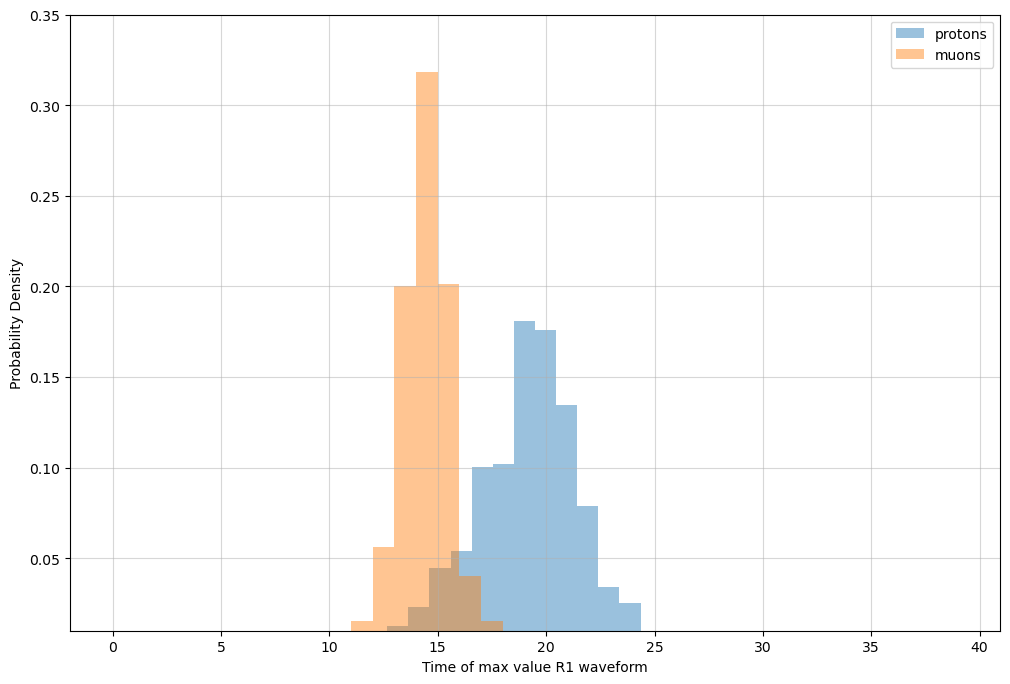

In [36]:
ring_stack = np.concatenate((ring_2223, ring_9222,ring_2438, ring_25051, ring_14406, ring_22126, ring_22365, ring_32298, ring_35219, ring_8234, ring_8448, ring_9404, ring_9433, ring_27374, ring_28328, ring_28000, ring_35298), axis=None)
proton_stack = np.concatenate((proton_2223, proton_9222,proton_2438, proton_25051, proton_14406, proton_22126, proton_22365, proton_32298, proton_35219, proton_8234, proton_8448, proton_9404, proton_9433, proton_27374, proton_28328, proton_28000, proton_35298), axis=None)
plt.figure(figsize=(12,8))
plt.hist(proton_stack, density = True, alpha = 0.45, bins = 39,label = 'protons')
plt.hist(ring_stack, density = True, alpha = 0.45,bins =39,label = 'muons')
#plt.title("Distribution of pixel waveform peak times for contaminated muon rings (17 Events)")
plt.xlabel("Time of max value R1 waveform")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha = 0.5)
plt.ylim(0.01,0.35)
#plt.savefig("/Users/vdk/ImagePurgatorium/TimeSamplesHistogram.png")
print(len(ring_stack), len(proton_stack))

In [37]:
event_waveforms = {}
muon_waveforms_obs = []
foldername = '/Users/vdk/RealLST/waveforms_obs14948/'
for filename in os.listdir(foldername):
    #event_waveforms[filename[10:16]] = np.load('/Users/vdk/UnrealLST/waveforms/' + filename)
    #event_waveforms[filename[10:16]] = np.load('/Users/vdk/RealLST/waveforms/' + filename)
    muon_waveforms_obs.append(np.load(foldername + filename, allow_pickle=True))

str_rings = [str(number) for number in flagged_rings_sim]

flag = True
counter = 0
counter = 0
proton_waveforms_obs = []
#for filename2 in os.listdir('/Users/vdk/UnrealLST/waveformsProton/'):

foldername = '/Users/vdk/RealLST/protons_obs14948/'
for filename2 in os.listdir(foldername):
  proton_waveforms_obs.append(np.load(foldername + filename2, allow_pickle=True))
  if counter == 1000:
    break


min_time = 7
max_time = 12

arr_max_muons = []
arg_max_muons = []

arg_max_muons_mask = []


variance_muon = []


muon_pixel_number = []

for waveform in muon_waveforms_obs:
   tmp_var_muon = []
   tmp_pixel = 0
   pixel_mask = np.array(np.max(waveform, axis = 1) > 2.5, dtype = bool)
   for pixel in waveform[pixel_mask]:
      arg_max_muons_mask.append(np.argmax(pixel))
      tmp_pixel += 1
    
   for pixel in waveform[:, min_time:max_time]:
      tmp_var_muon.append(np.var(pixel))
   
   variance_muon.append(tmp_var_muon)
   muon_pixel_number.append(tmp_pixel)


arg_max_protons = []
arg_max_protons_mask = []
variance_proton = []
proton_pixel_number = []

for waveform in proton_waveforms_obs:
   tmp_var_proton = []
   tmp_pixel = 0
   if True:
      pixel_mask = np.array(np.max(waveform, axis = 1) > 2.5, dtype = bool)
      for pixel in waveform[pixel_mask]:
        arg_max_protons_mask.append(np.argmax(pixel))
        tmp_pixel += 1
      
      for pixel in waveform[:, min_time:max_time]:
        tmp_var_proton.append(np.var(pixel))

   variance_proton.append(tmp_var_proton)
   proton_pixel_number.append(tmp_pixel)


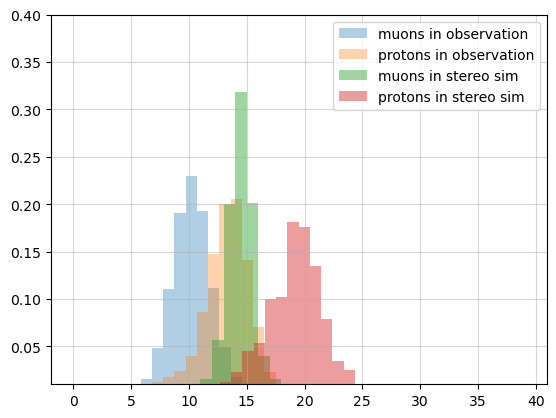

In [38]:
bin_number = 40
var_hist_m_short = [np.mean(np.array(item)) for item in variance_muon] # only for considered time span (7:12)
var_hist_p_short = [np.mean(np.array(item)) for item in variance_proton]
plt.hist(arg_max_muons_mask, bins = bin_number-4, density = True, alpha = 0.35, label = 'muons in observation')
plt.hist(arg_max_protons_mask, bins = bin_number-4, density = True, alpha = 0.35, label = 'protons in observation')

plt.hist(ring_stack, density = True, alpha = 0.45,bins =39,label = 'muons in stereo sim')
plt.hist(proton_stack, density = True, alpha = 0.45, bins = 39,label = 'protons in stereo sim')
plt.grid(alpha = 0.5)
plt.ylim(0.01,0.4)
plt.legend()

## Cleaning graphs for observations and mono simulations

### Reading muon fits tables with optical efficiency

In [10]:
# CLEANED SIMULATION
time_sample = 17
opt_eff_sim_clean = []
containment_sim = []
completeness_sim = []
event_id_sim_clean = []
muon_id_sim = []
efficiency_dict_sim_clean = {}
for i in range(1,100):
    #filename = f'/Users/vdk/UnrealLST/output_clean{time_sample}_mc/muon_table_run{i}.fits'
    filename = f'/Users/vdk/UnrealLST/table_muons_clean_afterFlag/muon_table_run{i}.fits'
    hdul = fits.open(filename)
    # element number 10 is muon efficiency, so in such way we can check it
    for i in range(len(hdul[1].data)):
        if not np.isnan(hdul[1].data[i][10]):
            containment_sim.append(hdul[1].data[i][11])
            completeness_sim.append(hdul[1].data[i][12])
            event_id_sim_clean.append(hdul[1].data[i][0])
            opt_eff_sim_clean.append(hdul[1].data[i][10])
            muon_id_sim.append(hdul[1].data[i][0])
            efficiency_dict_sim_clean[hdul[1].data[i][0]] = hdul[1].data[i][10]


# RAW SIMULATION
opt_eff_sim_raw = []
containment_raw = []
completeness_raw = []
event_id_sim_raw = []
muon_id_raw = []
efficiency_dict_sim_raw = {}
for i in range(1,100):
    filename = f'/Users/vdk/UnrealLST/muons_output_raw/muon_table_run{i}.fits'
    hdul = fits.open(filename)
    for i in range(len(hdul[1].data)):
        containment_raw.append(hdul[1].data[i][11])
        completeness_raw.append(hdul[1].data[i][12])
        if not np.isnan(hdul[1].data[i][10]):
            opt_eff_sim_raw.append(hdul[1].data[i][10])
            event_id_sim_raw.append(hdul[1].data[i][0])
            muon_id_raw.append(hdul[1].data[i][0])
            efficiency_dict_sim_raw[hdul[1].data[i][0]] = hdul[1].data[i][10]


# CLEAN OBSERVATION
muon_file = '/Users/vdk/RealLST/cleaning/muons_LST-1.Run14948.0001_15.fits'
hdul = fits.open(muon_file)
hdul.info()
opt_eff_obs_clean = []
event_id_obs_clean = []
efficiency_dict_obs_clean = {}
for i in range(len(hdul[1].data)):
    if not np.isnan(hdul[1].data[i][10]):
        event_id_obs_clean.append(hdul[1].data[i][0])
        opt_eff_obs_clean.append(hdul[1].data[i][10])
        efficiency_dict_obs_clean[hdul[1].data[i][0]] = hdul[1].data[i][10]

# RAW OBSERVATION
muon_file = muon_file = '/Users/vdk/RealLST/muons_LST-1.Run14948.0001.fits'
hdul = fits.open(muon_file)
hdul.info()
opt_eff_obs_raw = []
event_id_obs_raw = []
efficiency_dict_obs_raw = {}
for i in range(len(hdul[1].data)):
    if not np.isnan(hdul[1].data[i][10]):
        event_id_obs_raw.append(hdul[1].data[i][0])
        opt_eff_obs_raw.append(hdul[1].data[i][10])
        efficiency_dict_obs_raw[hdul[1].data[i][0]] = hdul[1].data[i][10]



Filename: /Users/vdk/RealLST/cleaning/muons_LST-1.Run14948.0001_15.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     54   72R x 23C   [K, D, K, E, E, D, D, D, D, L, D, D, D, D, D, D, D, D, D, K, D, K, K]   
Filename: /Users/vdk/RealLST/muons_LST-1.Run14948.0001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     54   68R x 23C   [K, D, K, E, E, D, D, D, D, L, D, D, D, D, D, D, D, D, D, K, D, K, K]   


### Building new arrays for simulations

In [11]:
# dictionary with event:opticalefficiency for raw events
res_dict = {event_id_sim_raw[i]:opt_eff_sim_raw[i] for i in range(len(opt_eff_sim_raw))}
# dictionary with event:opticalefficiency for cleaned events
res_dict_cleaned = {event_id_sim_clean[i]:opt_eff_sim_clean[i] for i in range(len(opt_eff_sim_clean))}


plot = []
only_raw_key = []

for i in res_dict_cleaned.keys():
    if i in res_dict.keys():
        plot.append(res_dict[i])
    else:
        only_raw_key.append(i)
        plot.append(0)

new_plot = []
new_ind = []
new_std = []

for i,j in enumerate(plot):
    if not j == 0:
        new_plot.append(j)
        new_ind.append(i)
        new_std.append(np.std(new_plot))


only_clean_ind = []
only_clean_val = []
only_clean_std = []
for i,j in enumerate(opt_eff_sim_clean):
    if i not in new_ind:
        only_clean_ind.append(i)
        only_clean_val.append(j)
        only_clean_std.append(np.std(opt_eff_sim_clean))


both_clean_ind = []
both_clean_val = []
both_clean_std = []

for i,j in enumerate(opt_eff_sim_clean):
    if i in new_ind:
        both_clean_ind.append(i)
        both_clean_val.append(j)
        both_clean_std.append(np.std(opt_eff_sim_clean))



### Plotting graphs for simulations

Number of simulated events before cleaning = 53
Number of simulated events after cleaning = 73
Optical efficiency before cleaning = 0.16209451851385526
Optical efficiency after cleaning = 0.1622376213704422


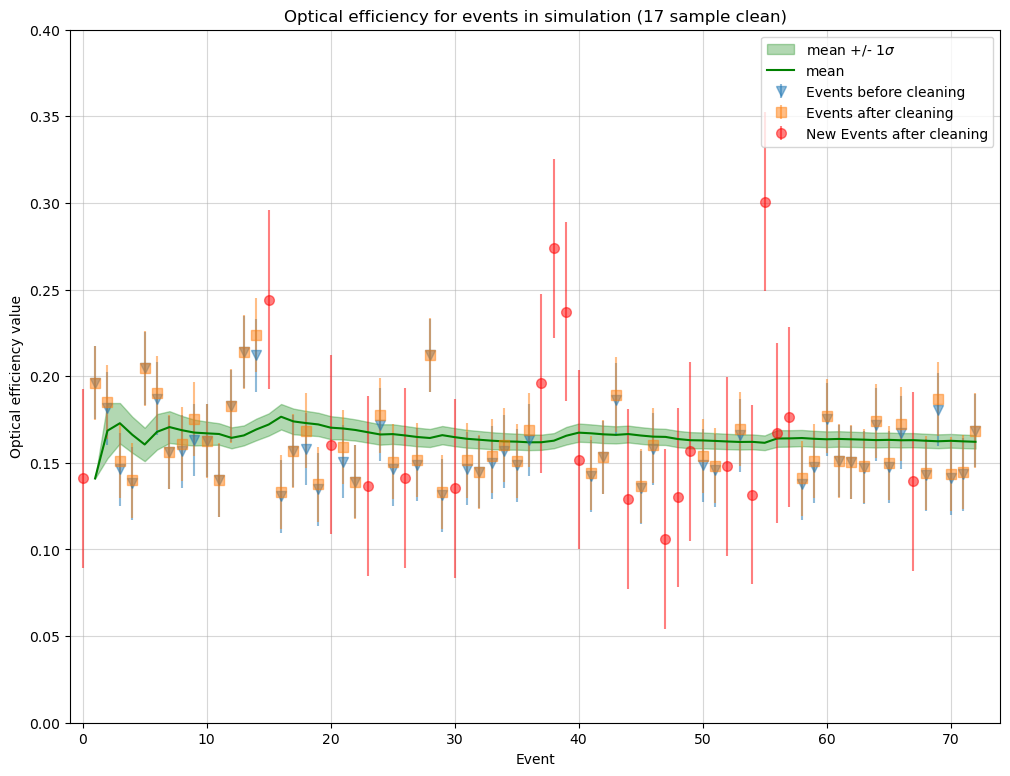

In [15]:
opt_eff = opt_eff_sim_clean
mean_range = [i-1 for i in range(len(opt_eff)+2)]
y_mid = [np.mean(opt_eff) for i in mean_range]

y_upper = [np.mean(opt_eff)+np.std(opt_eff) for i in mean_range]
y_lower = [np.mean(opt_eff)-np.std(opt_eff) for i in mean_range]

x_range = [i for i in range(len(opt_eff_sim_clean))]




# std_arr = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
# std_arr_3 = [np.std(new_plot)/(i+1)**0.5 for i,j in enumerate(new_plot)]
# std_arr_4 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in only_clean_ind]
# std_arr_5 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in both_clean_ind]


std_arr = [np.std(opt_eff_sim_clean) for i,j in enumerate(opt_eff_sim_clean)]
std_arr_3 = [np.std(new_plot) for i,j in enumerate(new_plot)]
std_arr_4 = [np.std(only_clean_val) for i in only_clean_ind]
std_arr_5 = [np.std(both_clean_val) for i in both_clean_ind]

# std_arr = [np.std(opt_eff_sim_clean)/(0+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
# std_arr_3 = [np.std(new_plot)/(0+1)**0.5 for i,j in enumerate(new_plot)]
# std_arr_4 = [np.std(opt_eff_sim_clean)/(0+1)**0.5 for i in only_clean_ind]
# std_arr_5 = [np.std(opt_eff_sim_clean)/(0+1)**0.5 for i in both_clean_ind]


plt.figure(figsize = (12,9))
plt.xlabel("Event")
plt.ylabel("Optical efficiency value")
plt.title(f"Optical efficiency for events in simulation ({time_sample} sample clean)")


plt.grid(alpha=0.5)
plt.ylim(0.05,0.64)
plt.ylim(0.08,0.32)
plt.ylim(0,0.4)


#y_upper = [j+std_arr[-1] for i,j in enumerate(y_mid)]
#y_lower = [j-std_arr[-1] for i,j in enumerate(y_mid)]


y_upper = [j+std_arr[-1] for i,j in enumerate([np.mean(opt_eff) for i in x_range])]
y_lower = [j-std_arr[-1] for i,j in enumerate([np.mean(opt_eff) for i in x_range])]

# Cumulative mean that changes
std_arr = [np.std(opt_eff_sim_clean[:i])/(i+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
y_upper = [j+std_arr[i] for i,j in enumerate([np.mean(opt_eff_sim_clean[:i]) for i in x_range])]
y_lower = [j-std_arr[i] for i,j in enumerate([np.mean(opt_eff_sim_clean[:i]) for i in x_range])]

#plt.errorbar(x_range, opt_eff_sim_clean, yerr=std_arr, fmt='o', ms = 5, alpha = 0.8, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')
plt.errorbar(both_clean_ind, both_clean_val, yerr=std_arr_5, fmt='v', ms = 7, alpha = 0.5, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')

plt.errorbar(new_ind, new_plot, yerr=std_arr_3, fmt='s', ms = 7, alpha = 0.5, label="Events after cleaning")
plt.errorbar(only_clean_ind, only_clean_val, yerr=std_arr_4, fmt='o', ms = 7, alpha = 0.5, color = 'red', label="New Events after cleaning")

plt.fill_between(x_range, y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
plt.plot(x_range, [np.mean(opt_eff_sim_clean[:i]) for i in x_range], label = "mean", lw = 1.5, color='green')

plt.xlim(-1,len(opt_eff_sim_clean)+1)
plt.legend()
print(f"Number of simulated events before cleaning = {len(opt_eff_sim_raw)}")
print(f"Number of simulated events after cleaning = {len(opt_eff_sim_clean)}")
print(f"Optical efficiency before cleaning = {np.mean(opt_eff_sim_raw)}")
print(f"Optical efficiency after cleaning = {np.mean(opt_eff_sim_clean)}")
#print(f"Optical efficiency std  after cleaning = {np.std(opt_eff_sim_clean)}")
#plt.savefig(f"/Users/vdk/ImagePurgatorium/LST1_14948_OptEffSimClean_{time_sample}sample.png", dpi=900)

Number of simulated events before cleaning = 53
Number of simulated events after cleaning = 71
Optical efficiency before cleaning = 0.16209451851385526
Optical efficiency after cleaning = 0.16005750286903955


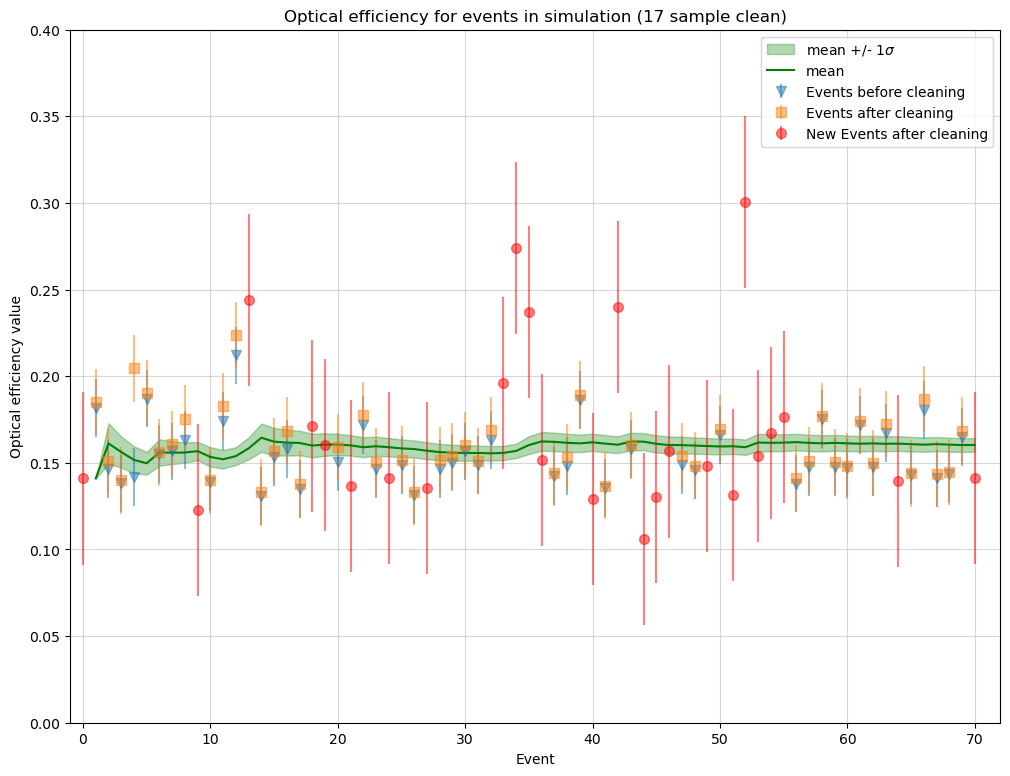

In [9]:
opt_eff = opt_eff_sim_clean
mean_range = [i-1 for i in range(len(opt_eff)+2)]
y_mid = [np.mean(opt_eff) for i in mean_range]

y_upper = [np.mean(opt_eff)+np.std(opt_eff) for i in mean_range]
y_lower = [np.mean(opt_eff)-np.std(opt_eff) for i in mean_range]

x_range = [i for i in range(len(opt_eff_sim_clean))]




# std_arr = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
# std_arr_3 = [np.std(new_plot)/(i+1)**0.5 for i,j in enumerate(new_plot)]
# std_arr_4 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in only_clean_ind]
# std_arr_5 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in both_clean_ind]


std_arr = [np.std(opt_eff_sim_clean) for i,j in enumerate(opt_eff_sim_clean)]
std_arr_3 = [np.std(new_plot) for i,j in enumerate(new_plot)]
std_arr_4 = [np.std(only_clean_val) for i in only_clean_ind]
std_arr_5 = [np.std(both_clean_val) for i in both_clean_ind]

# std_arr = [np.std(opt_eff_sim_clean)/(0+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
# std_arr_3 = [np.std(new_plot)/(0+1)**0.5 for i,j in enumerate(new_plot)]
# std_arr_4 = [np.std(opt_eff_sim_clean)/(0+1)**0.5 for i in only_clean_ind]
# std_arr_5 = [np.std(opt_eff_sim_clean)/(0+1)**0.5 for i in both_clean_ind]


plt.figure(figsize = (12,9))
plt.xlabel("Event")
plt.ylabel("Optical efficiency value")
plt.title(f"Optical efficiency for events in simulation ({time_sample} sample clean)")


plt.grid(alpha=0.5)
plt.ylim(0.05,0.64)
plt.ylim(0.0,0.4)


#y_upper = [j+std_arr[-1] for i,j in enumerate(y_mid)]
#y_lower = [j-std_arr[-1] for i,j in enumerate(y_mid)]


y_upper = [j+std_arr[-1] for i,j in enumerate([np.mean(opt_eff) for i in x_range])]
y_lower = [j-std_arr[-1] for i,j in enumerate([np.mean(opt_eff) for i in x_range])]

# Cumulative mean that changes
std_arr = [np.std(opt_eff_sim_clean[:i])/(i+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
y_upper = [j+std_arr[i] for i,j in enumerate([np.mean(opt_eff_sim_clean[:i]) for i in x_range])]
y_lower = [j-std_arr[i] for i,j in enumerate([np.mean(opt_eff_sim_clean[:i]) for i in x_range])]

#plt.errorbar(x_range, opt_eff_sim_clean, yerr=std_arr, fmt='o', ms = 5, alpha = 0.8, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')
plt.errorbar(both_clean_ind, both_clean_val, yerr=std_arr_5, fmt='v', ms = 7, alpha = 0.5, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')

plt.errorbar(new_ind, new_plot, yerr=std_arr_3, fmt='s', ms = 7, alpha = 0.5, label="Events after cleaning")
plt.errorbar(only_clean_ind, only_clean_val, yerr=std_arr_4, fmt='o', ms = 7, alpha = 0.5, color = 'red', label="New Events after cleaning")

plt.fill_between(x_range, y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
plt.plot(x_range, [np.mean(opt_eff_sim_clean[:i]) for i in x_range], label = "mean", lw = 1.5, color='green')

plt.xlim(-1,len(opt_eff_sim_clean)+1)
plt.legend()
print(f"Number of simulated events before cleaning = {len(opt_eff_sim_raw)}")
print(f"Number of simulated events after cleaning = {len(opt_eff_sim_clean)}")
print(f"Optical efficiency before cleaning = {np.mean(opt_eff_sim_raw)}")
print(f"Optical efficiency after cleaning = {np.mean(opt_eff_sim_clean)}")
#plt.savefig(f"/Users/vdk/ImagePurgatorium/LST1_14948_OptEffSimClean_{time_sample}sample.png", dpi=900)

### Building new event arrays for observations

In [49]:
# dictionary with event:opticalefficiency for raw events
res_dict = {event_id_obs_raw[i]:opt_eff_obs_raw[i] for i in range(len(opt_eff_obs_raw))}
# dictionary with event:opticalefficiency for cleaned events
res_dict_cleaned = {event_id_obs_clean[i]:opt_eff_obs_clean[i] for i in range(len(opt_eff_obs_clean))}


plot = []
only_raw_key = []

for i in res_dict_cleaned.keys():
    if i in res_dict.keys():
        plot.append(res_dict[i])
    else:
        only_raw_key.append(i)
        plot.append(0)

both_raw_val = []
both_raw_ind = []
both_raw_std = []

for i,j in enumerate(plot):
    if not j == 0:
        both_raw_val.append(j)
        both_raw_ind.append(i)
        both_raw_std.append(np.std(both_raw_val))


only_clean_ind = []
only_clean_val = []
only_clean_std = []
for i,j in enumerate(opt_eff_obs_clean):
    if i not in both_raw_ind:
        only_clean_ind.append(i)
        only_clean_val.append(j)
        only_clean_std.append(np.std(opt_eff_obs_clean))


both_clean_ind = []
both_clean_val = []
both_clean_std = []

for i,j in enumerate(opt_eff_obs_clean):
    if i in both_raw_ind:
        both_clean_ind.append(i)
        both_clean_val.append(j)
        both_clean_std.append(np.std(opt_eff_obs_clean))


### Plotting graphs for observations

Number of observed events before cleaning = 68
Number of observed events after cleaning = 72
Optical efficiency before cleaning = 0.16539152796604775
Optical efficiency after cleaning = 0.16492797913052382
72
72


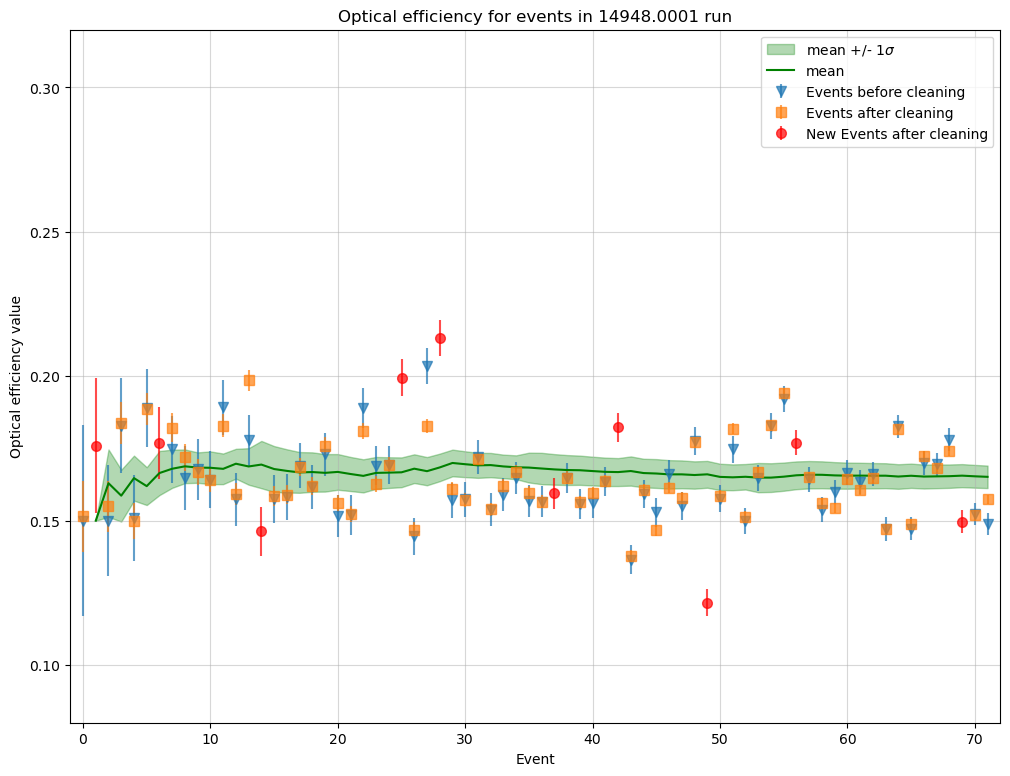

In [50]:
opt_eff = opt_eff_sim_clean
mean_range = [i-1 for i in range(len(opt_eff)+2)]
y_mid = [np.mean(opt_eff) for i in mean_range]

y_upper = [np.mean(opt_eff[:i])+np.std(opt_eff[:i]) for i in mean_range]
y_lower = [np.mean(opt_eff[:i])-np.std(opt_eff[:i]) for i in mean_range]

x_range = [i for i in range(len(opt_eff_obs_clean))]




std_arr = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
std_arr_3 = [np.std(both_raw_val)/(i+1)**0.5 for i,j in enumerate(both_raw_val)]
std_arr_4 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in only_clean_ind]
std_arr_5 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in both_clean_ind]


plt.figure(figsize = (12,9))
plt.xlabel("Event")
plt.ylabel("Optical efficiency value")
plt.title("Optical efficiency for events in 14948.0001 run")


plt.grid(alpha=0.5)
plt.ylim(0.08,0.32)


#y_upper = [j+std_arr[-1] for i,j in enumerate(y_mid)]
#y_lower = [j-std_arr[-1] for i,j in enumerate(y_mid)]


y_upper = [j+std_arr[-1] for i,j in enumerate([np.mean(opt_eff_obs_clean) for i in x_range])]
y_lower = [j-std_arr[-1] for i,j in enumerate([np.mean(opt_eff_obs_clean) for i in x_range])]


# Cumulative mean that changes
std_arr = [np.std(opt_eff_sim_clean[:i])/(i+1)**0.5 for i,j in enumerate(opt_eff_obs_clean)]
y_upper = [j+std_arr[i] for i,j in enumerate([np.mean(opt_eff_obs_clean[:i]) for i in x_range])]
y_lower = [j-std_arr[i] for i,j in enumerate([np.mean(opt_eff_obs_clean[:i]) for i in x_range])]

#plt.errorbar(x_range, opt_eff_sim_clean, yerr=std_arr, fmt='o', ms = 5, alpha = 0.8, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')


plt.errorbar(both_clean_ind, both_clean_val, yerr=std_arr_5, fmt='v', ms = 7, alpha = 0.7, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')

plt.errorbar(both_raw_ind, both_raw_val, yerr=std_arr_3, fmt='s', ms = 7, alpha = 0.7, label="Events after cleaning")


plt.errorbar(only_clean_ind, only_clean_val, yerr=std_arr_4, fmt='o', ms = 7, alpha = 0.7, color = 'red', label="New Events after cleaning")

plt.fill_between(x_range, y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
#plt.fill_between([np.mean(opt_eff_obs_clean[:i]) for i in x_range], y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
plt.plot(x_range, [np.mean(opt_eff_obs_clean[:i]) for i in x_range], label = "mean", lw = 1.5, color='green')

plt.xlim(-1,len(opt_eff_obs_clean))
plt.legend()
print(f"Number of observed events before cleaning = {len(opt_eff_obs_raw)}")
print(f"Number of observed events after cleaning = {len(opt_eff_obs_clean)}")
print(f"Optical efficiency before cleaning = {np.mean(opt_eff_obs_raw)}")
print(f"Optical efficiency after cleaning = {np.mean(opt_eff_obs_clean)}")
#plt.savefig("/Users/vdk/ImagePurgatorium/LST1_14948_OptEffRaw.png", dpi=900)
print(len(std_arr))
print(len(y_upper))

Number of observed events before cleaning = 68
Number of observed events after cleaning = 72
Optical efficiency before cleaning = 0.16539152796604775
Optical efficiency after cleaning = 0.16492797913052382
72
72


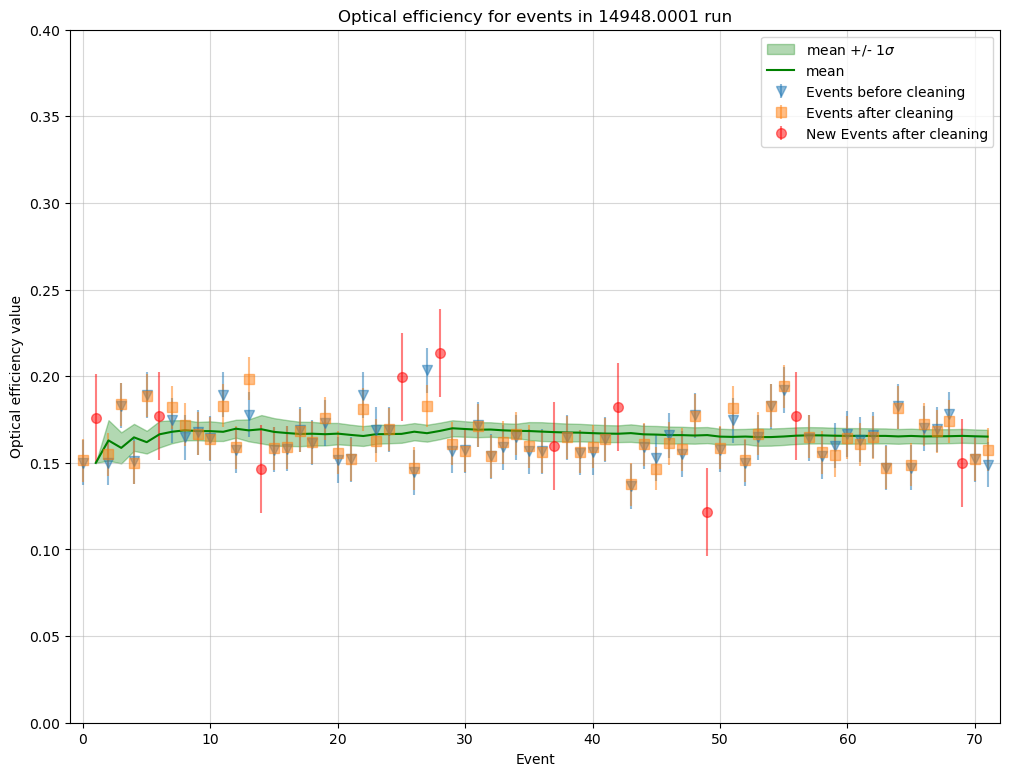

In [52]:
opt_eff = opt_eff_sim_clean
mean_range = [i-1 for i in range(len(opt_eff)+2)]
y_mid = [np.mean(opt_eff) for i in mean_range]

y_upper = [np.mean(opt_eff[:i])+np.std(opt_eff[:i]) for i in mean_range]
y_lower = [np.mean(opt_eff[:i])-np.std(opt_eff[:i]) for i in mean_range]

x_range = [i for i in range(len(opt_eff_obs_clean))]




std_arr = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i,j in enumerate(opt_eff_sim_clean)]
std_arr_3 = [np.std(both_raw_val)/(i+1)**0.5 for i,j in enumerate(both_raw_val)]
std_arr_4 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in only_clean_ind]
std_arr_5 = [np.std(opt_eff_sim_clean)/(i+1)**0.5 for i in both_clean_ind]


std_arr = [np.std(opt_eff_sim_clean) for i,j in enumerate(opt_eff_sim_clean)]
std_arr_3 = [np.std(both_raw_val) for i,j in enumerate(both_raw_val)]
std_arr_4 = [np.std(only_clean_val) for i in only_clean_ind]
std_arr_5 = [np.std(both_clean_val) for i in both_clean_ind]


plt.figure(figsize = (12,9))
plt.xlabel("Event")
plt.ylabel("Optical efficiency value")
plt.title("Optical efficiency for events in 14948.0001 run")


plt.grid(alpha=0.5)
plt.ylim(0,0.4)


#y_upper = [j+std_arr[-1] for i,j in enumerate(y_mid)]
#y_lower = [j-std_arr[-1] for i,j in enumerate(y_mid)]


y_upper = [j+std_arr[-1] for i,j in enumerate([np.mean(opt_eff_obs_clean) for i in x_range])]
y_lower = [j-std_arr[-1] for i,j in enumerate([np.mean(opt_eff_obs_clean) for i in x_range])]


# Cumulative mean that changes
std_arr = [np.std(opt_eff_sim_clean[:i])/(i+1)**0.5 for i,j in enumerate(opt_eff_obs_clean)]
y_upper = [j+std_arr[i] for i,j in enumerate([np.mean(opt_eff_obs_clean[:i]) for i in x_range])]
y_lower = [j-std_arr[i] for i,j in enumerate([np.mean(opt_eff_obs_clean[:i]) for i in x_range])]

#plt.errorbar(x_range, opt_eff_sim_clean, yerr=std_arr, fmt='o', ms = 5, alpha = 0.8, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')


plt.errorbar(both_clean_ind, both_clean_val, yerr=std_arr_5, fmt='v', ms = 7, alpha = 0.5, label="Events before cleaning")#, c = 'blue')#, s = 100)#, c= 'black')

plt.errorbar(both_raw_ind, both_raw_val, yerr=std_arr_3, fmt='s', ms = 7, alpha = 0.5, label="Events after cleaning")


plt.errorbar(only_clean_ind, only_clean_val, yerr=std_arr_4, fmt='o', ms = 7, alpha = 0.5, color = 'red', label="New Events after cleaning")

plt.fill_between(x_range, y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
#plt.fill_between([np.mean(opt_eff_obs_clean[:i]) for i in x_range], y_upper, y_lower, alpha = 0.3, color = 'green', label = 'mean +/- $1\sigma$')
plt.plot(x_range, [np.mean(opt_eff_obs_clean[:i]) for i in x_range], label = "mean", lw = 1.5, color='green')

plt.xlim(-1,len(opt_eff_obs_clean))
plt.legend()
print(f"Number of observed events before cleaning = {len(opt_eff_obs_raw)}")
print(f"Number of observed events after cleaning = {len(opt_eff_obs_clean)}")
print(f"Optical efficiency before cleaning = {np.mean(opt_eff_obs_raw)}")
print(f"Optical efficiency after cleaning = {np.mean(opt_eff_obs_clean)}")
#plt.savefig("/Users/vdk/ImagePurgatorium/LST1_14948_OptEffRaw.png", dpi=900)
print(len(std_arr))
print(len(y_upper))

## Precision/Recall statistic for flagging

### TP FP TN FN for observaion 14948.0001

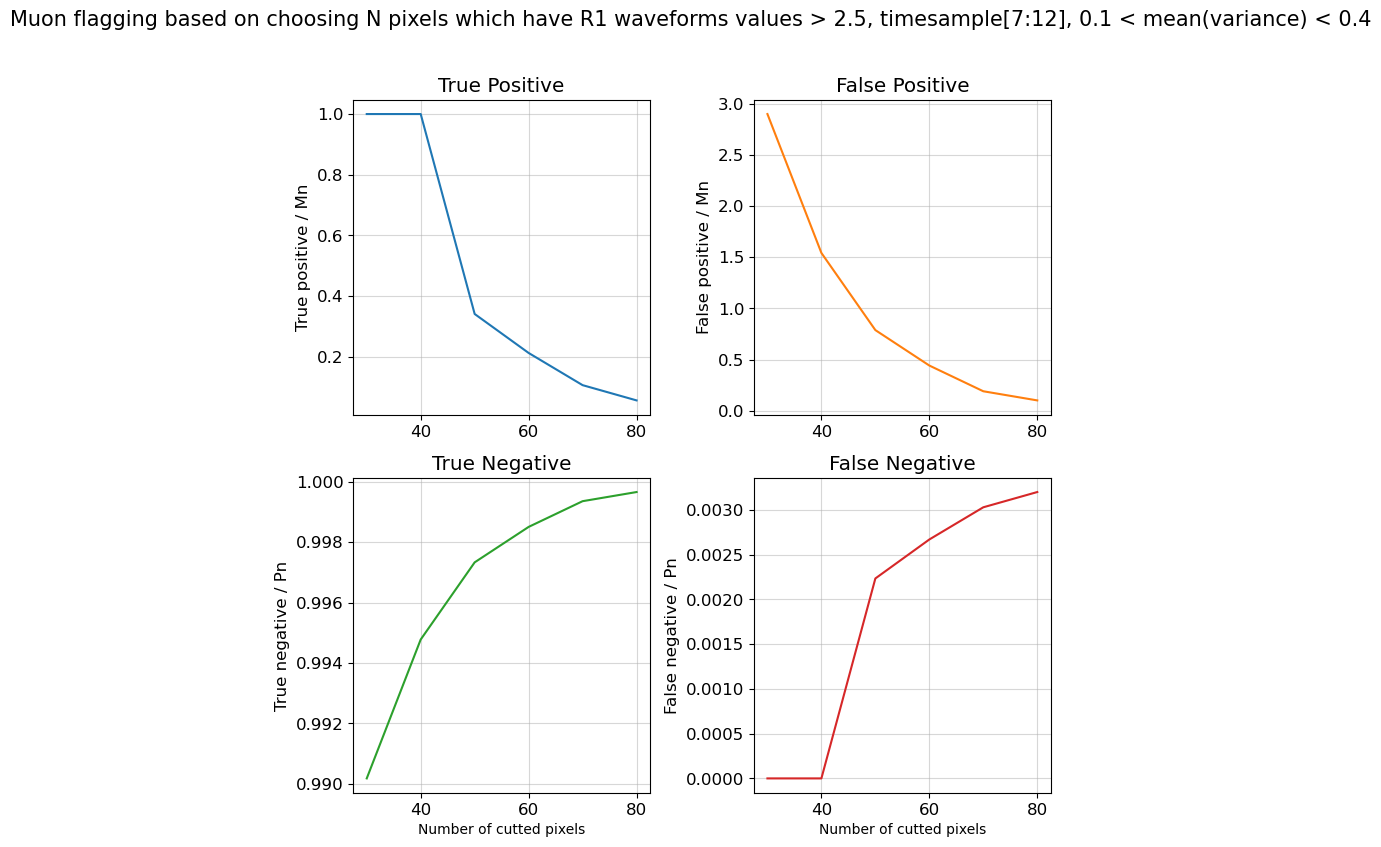

In [19]:
#M_n = 68 # lstchain found rings
M_n = 179 # Full new muons
P_n = 53000-M_n
cuts = np.array([30, 40, 50, 60, 70, 80]) #, 90])
muons_detected = np.array([179, 179, 61, 38, 19, 10]) #, 4]) # All muons in subrun
#muons_detected = np.array([68, 68, 61, 38, 19, 10]) #, 4]) # lstchain found muons
protons_detected = np.array([519, 276, 141, 79, 34, 18]) #, 9]) - muons_detected

true_negative = P_n - protons_detected
false_negative = M_n - muons_detected 
R1_cut = 2.5

plt.rcParams.update({'font.size': 12, 'figure.figsize': (9,9)})
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.2, wspace = 0.35)
fig.suptitle(f"Muon flagging based on choosing N pixels which have R1 waveforms values > {R1_cut}, timesample[7:12], 0.1 < mean(variance) < 0.4", fontsize = 15)

axs[0, 0].plot(cuts, muons_detected/M_n)
axs[0, 0].set_title('True Positive')
#axs[0, 0].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 0].set_ylabel("True positive / Mn")

axs[0, 1].plot(cuts, (protons_detected)/M_n, 'tab:orange')
axs[0, 1].set_title('False Positive')
#axs[0, 1].set_xlabel("Number of cutted pixels", fontsize = 7)
axs[0, 1].set_ylabel("False positive / Mn")

axs[1, 0].plot(cuts, true_negative/P_n, 'tab:green')
axs[1, 0].set_title('True Negative')
axs[1, 0].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 0].set_ylabel("True negative / Pn")

axs[1, 1].plot(cuts, false_negative/P_n, 'tab:red')
axs[1, 1].set_title('False Negative')
axs[1, 1].set_xlabel("Number of cutted pixels", fontsize = 10)
axs[1, 1].set_ylabel("False negative / Pn")
for ax in axs.flat:
    ax.grid(alpha = 0.5)

#plt.savefig(f"/Users/vdk/ImagePurgatorium/PixelCut_R1waveform>{R1_cut}_Time+Variance.png")

### Data/2 simulation comparison

precision =  [0.13102119 0.24637681 0.43262411 0.48101266 0.55882353 0.55555556]
recal =  [1.         1.         0.89705882 0.55882353 0.27941176 0.14705882]


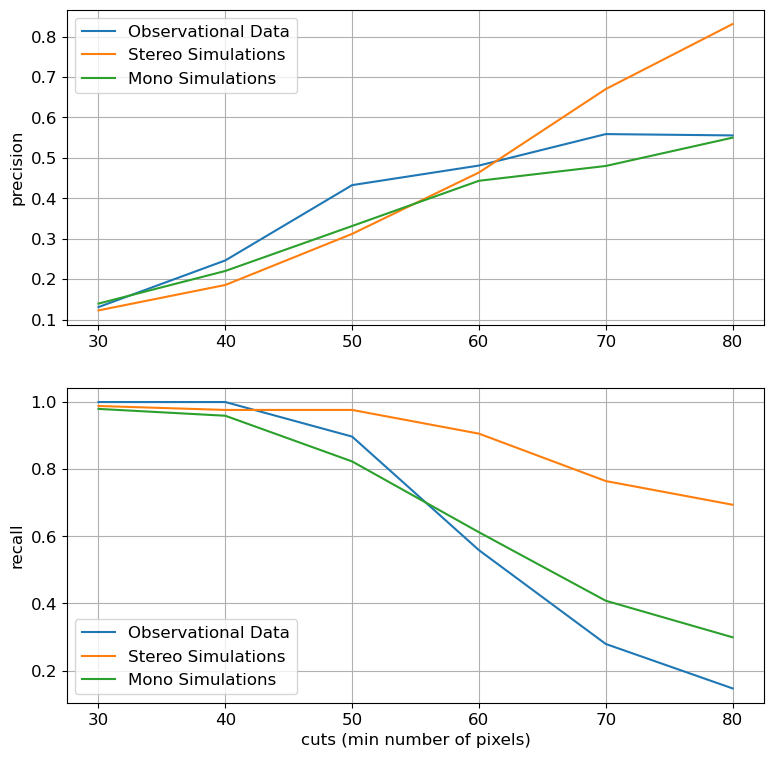

In [20]:
M_n = 68
P_n = 53000-M_n
cuts = np.array([30, 40, 50, 60, 70, 80]) #, 90])
muons_detected = np.array([68, 68, 61, 38, 19, 10]) #, 4])
protons_detected = np.array([519, 276, 141, 79, 34, 18]) - muons_detected #, 9]) - muons_detected

M_n_sim = 85
P_n_sim = 14517-85
cuts_sim = np.array([30, 40, 50, 60, 70, 80]) # , 90])
#muons_detected_sim = np.array([85, 83, 79, 67, 55, 49]) #, 45])
muons_detected_sim = np.array([84, 83, 83, 77, 65, 59])
protons_detected_sim = np.array([684, 447, 266, 166, 97, 71])- muons_detected_sim #, 49]) - muons_detected_sim

M_n_sim_mono = 147
P_n_sim_mono = 42750-M_n_sim_mono
cuts_sim_mono = np.array([30, 40, 50, 60, 70, 80])
muons_detected_sim_mono = np.array([51, 51, 50, 44, 36, 27])
#muons_detected_sim_mono = np.array([53, 53, 49, 43, 37, 31])
muons_detected_sim_mono = np.array([144, 141, 121, 90, 60, 44])

#muons_detected_sim_mono = np.array([144, 130, 114, 71, 40, 23]) # 2.5

#protons_detected_sim_mono = np.array([1152, 734, 433, 254, 160, 104])- muons_detected_sim_mono
protons_detected_sim_mono = np.array([1031, 640, 365, 203, 125, 80])- muons_detected_sim_mono

#protons_detected_sim_mono = np.array([920, 508, 278, 161, 83, 51])- muons_detected_sim_mono # 2.5


# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected
precision = TP/(TP+FP)
recall = TP/(TP+FN)


TP_sim = muons_detected_sim
FP_sim = protons_detected_sim
TN_sim = P_n_sim - protons_detected_sim
FN_sim = M_n_sim - muons_detected_sim
precision_sim = TP_sim/(TP_sim+FP_sim)
recall_sim = TP_sim/(TP_sim+FN_sim)


TP_sim_mono = muons_detected_sim_mono
FP_sim_mono = protons_detected_sim_mono
TN_sim_mono = P_n_sim_mono - protons_detected_sim_mono
FN_sim_mono = M_n_sim_mono - muons_detected_sim_mono
precision_sim_mono = TP_sim_mono/(TP_sim_mono+FP_sim_mono)
recall_sim_mono = TP_sim_mono/(TP_sim_mono+FN_sim_mono)

print("precision = ", precision)
print("recal = ", recall)
#fig = plt.figure(figsize = (10,9))
_, ax = plt.subplots(2,1)

ax[0].plot(cuts, precision, label = 'Observational Data')
ax[0].plot(cuts, precision_sim, label = 'Stereo Simulations')
ax[0].plot(cuts_sim_mono, precision_sim_mono, label = 'Mono Simulations')
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("precision")
ax[1].set_xlabel("cuts (min number of pixels)")
ax[1].plot(cuts, recall, label = 'Observational Data')
ax[1].plot(cuts, recall_sim, label = 'Stereo Simulations')
ax[1].plot(cuts_sim_mono, recall_sim_mono, label = 'Mono Simulations')
ax[1].set_ylabel("recall")
ax[1].grid()
ax[1].legend()

### Precision/recall for all muon rings in observation

precision =  [0.33911368 0.63768116 0.82269504 0.87341772 0.85294118 0.83333333]
recal =  [0.99435028 0.99435028 0.65536723 0.38983051 0.16384181 0.08474576]


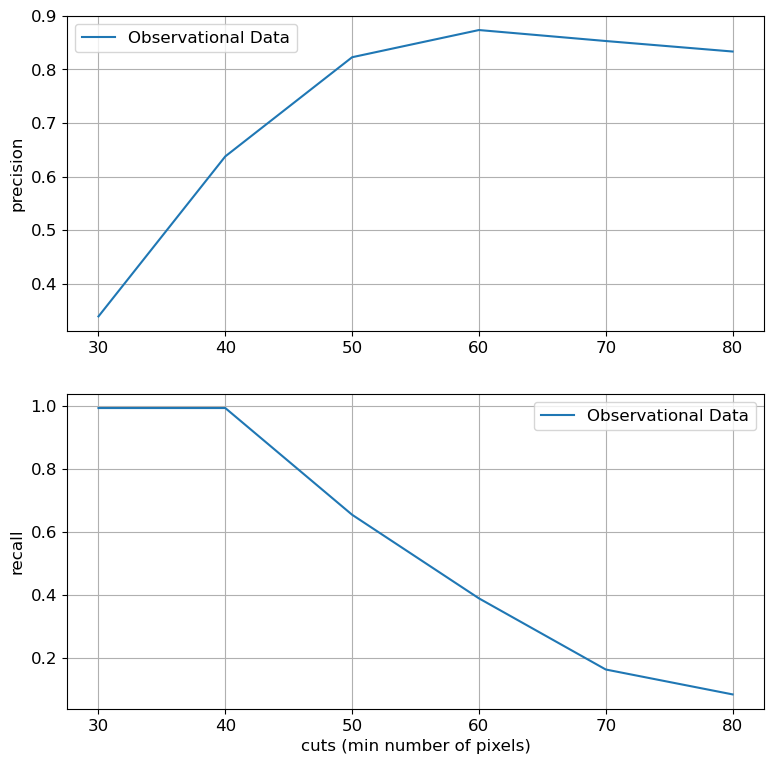

In [21]:
M_n = 177
P_n = 53000-M_n
cuts = np.array([30, 40, 50, 60, 70, 80]) #, 90])
muons_detected = np.array([176, 176, 116, 69, 29, 15]) #, 4])
protons_detected = np.array([519, 276, 141, 79, 34, 18]) - muons_detected #, 9]) - muons_detected


M_n_sim = 85
P_n_sim = 14517-85
cuts_sim = np.array([30, 40, 50, 60, 70, 80]) # , 90])
muons_detected_sim = np.array([85, 83, 79, 67, 55, 49]) #, 45])
protons_detected_sim = np.array([784, 447, 266, 166, 97, 71])- muons_detected_sim #, 49]) - muons_detected_sim
muons_detected_sim = np.array([83, 83, 83, 77, 65, 59])
protons_detected_sim = np.array([657, 447, 266, 166, 97, 71]) - muons_detected_sim

# PRECISION RECALL
TP = muons_detected
FP = protons_detected
TN = P_n - protons_detected
FN = M_n - muons_detected
precision = TP/(TP+FP)
recall = TP/(TP+FN)


TP_sim = muons_detected_sim
FP_sim = protons_detected_sim
TN_sim = P_n_sim - protons_detected_sim
FN_sim = M_n_sim - muons_detected_sim
precision_sim = TP_sim/(TP_sim+FP_sim)
recall_sim = TP_sim/(TP_sim+FN_sim)

print("precision = ", precision)
print("recal = ", recall)
#fig = plt.figure(figsize = (10,9))
_, ax = plt.subplots(2,1)

ax[0].plot(cuts, precision, label = 'Observational Data')
#ax[0].plot(cuts, precision_sim, label = 'Simulations')
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("precision")
ax[1].set_xlabel("cuts (min number of pixels)")
ax[1].plot(cuts, recall, label = 'Observational Data')
#ax[1].plot(cuts, recall_sim, label = 'Stereo simulations')
ax[1].set_ylabel("recall")
ax[1].grid()
ax[1].legend()

## R1 distributions for data and simulations